<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-from-S3" data-toc-modified-id="Read-from-S3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read from S3</a></span></li><li><span><a href="#Distributions" data-toc-modified-id="Distributions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Distributions</a></span></li><li><span><a href="#Describe-features" data-toc-modified-id="Describe-features-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Describe features</a></span></li><li><span><a href="#Hour-of-Day" data-toc-modified-id="Hour-of-Day-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hour of Day</a></span></li></ul></div>

Before rerunning this analysis, make a copy of this file. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import utils
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import SparkSession
import os

os.environ['TZ'] = 'UTC'

# Read from S3

After the data has been collected, the dataset size is relatively small with significant reduction over scraped dataset.

In [5]:
filename = 's3a://data-kennethmyers/model_data/redditAggregatedData-20230502.parquet'

In [6]:
cfg_file = utils.findConfig()
cfg = utils.parseConfig(cfg_file)
spark = (
  SparkSession
  .builder
  .appName('redditData')
  .config('spark.driver.extraJavaOptions', '-Duser.timezone=GMT') 
  .config('spark.executor.extraJavaOptions', '-Duser.timezone=GMT')
  .config('spark.sql.session.timeZone', 'UTC')
  .config("fs.s3a.access.key", cfg['ACCESSKEY'])
  .config("fs.s3a.secret.key", cfg['SECRETKEY'])
  .getOrCreate()
)
df = spark.read.parquet(filename).toPandas()

# Distributions

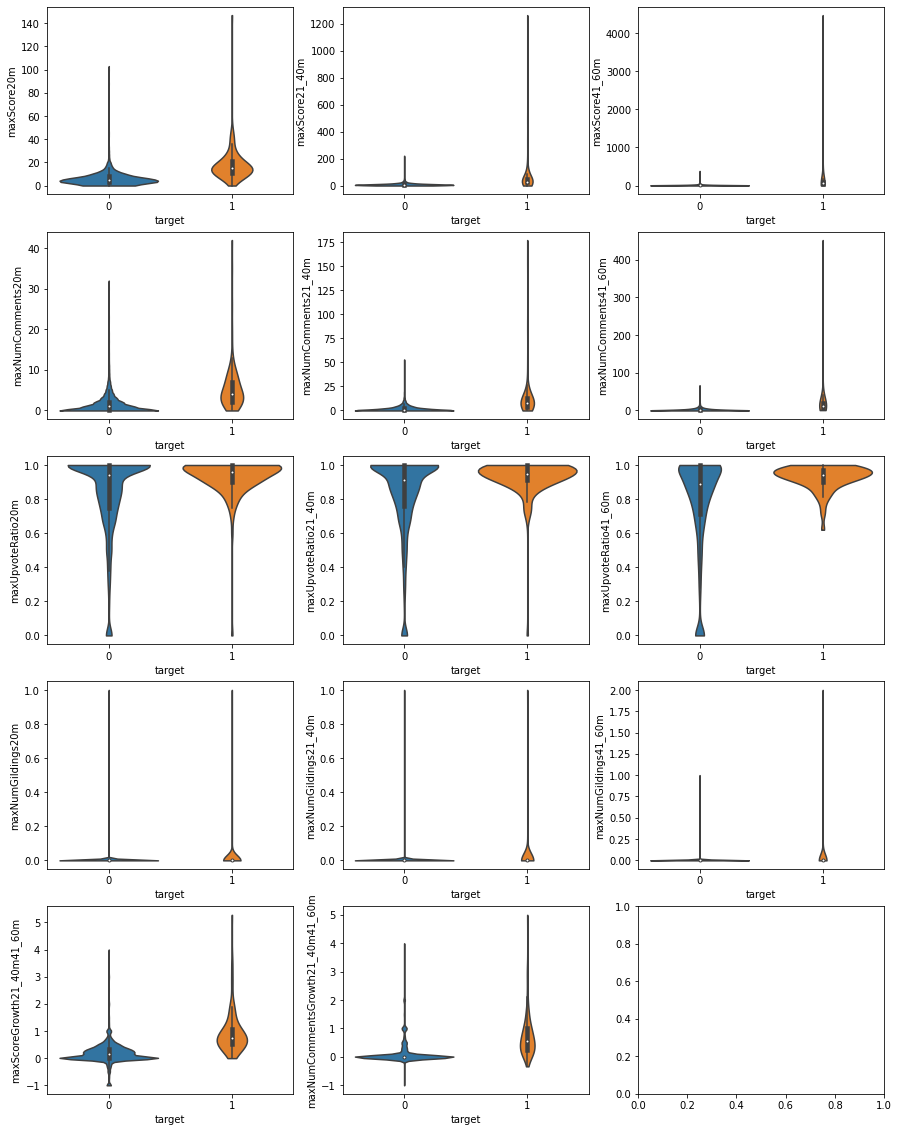

In [15]:
df = df.fillna(0)

featureColumns = df.columns[4:-1]
featureColumns = np.array(featureColumns)
featureColumns = np.pad(
  featureColumns, 
  (0, 5*3 - featureColumns.size), 
  mode='constant', 
  constant_values=''
).reshape(5,3)

fig, axes = plt.subplots(5, 3, figsize=(15, 20), sharey=False)

for i,row in enumerate(featureColumns):
  for j,col in enumerate(row):
    if col=='':
      continue
    sns.violinplot(data = df, x='target', y=col, ax=axes[i,j], cut=0)
    
plt.show()

- It looks like the maxScore could be one of the best features.
- numComments could also be predictive, looks like there is good mean separation, although the extremes of non-viral have high comment counts.
- maxUpvotedRatio is at later times seems like it could be predictive but not at the lower end.
- numGildings will probably be one of the weakest, it's generally constant (0).

# Describe features

In [16]:
for col in df.columns[4:-1]:
  print(col)
  subdf = df[[col, 'target']].groupby('target').describe()
  print(subdf.reset_index(drop=False).to_string())
  print()

maxScore20m
  target maxScore20m                                                    
               count       mean        std  min   25%   50%   75%    max
0      0      5480.0   5.790876   5.070490  0.0   3.0   5.0   8.0  103.0
1      1       147.0  17.714286  14.247807  0.0  10.5  15.0  21.0  147.0

maxScore21_40m
  target maxScore21_40m                                                      
                  count       mean         std  min   25%   50%   75%     max
0      0         5480.0   8.438504    8.815205  0.0   3.0   7.0  11.0   221.0
1      1          147.0  53.210884  113.919777  0.0  23.5  29.0  47.5  1265.0

maxScore41_60m
  target maxScore41_60m                                                       
                  count        mean         std  min   25%   50%   75%     max
0      0         5480.0   10.291241   12.841624  0.0   3.0   7.0  13.0   383.0
1      1          147.0  145.598639  459.974756  5.0  36.0  54.0  90.5  4481.0

maxNumComments20m
  target maxNumCo

# Hour of Day

Although post count is low right now, what does hour of day look like for virality

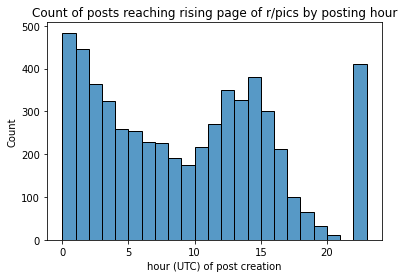

In [17]:
sns.histplot(df['createdTSUTC'].apply(lambda x: x.hour), binwidth=1)
plt.xlabel('hour (UTC) of post creation')
plt.title('Count of posts reaching rising page of r/pics by posting hour')
plt.show()

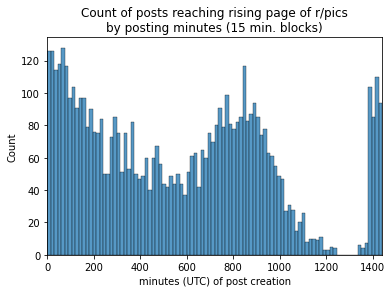

In [18]:
# this is just a higher resolution of the above plot, you can change the bin with to however many minutes
blockSize = 15
sns.histplot(df['createdTSUTC'].apply(lambda x: x.hour*60+x.minute), binwidth=blockSize)
plt.xlim(0,60*24)
plt.xlabel('minutes (UTC) of post creation')
plt.title(f'Count of posts reaching rising page of r/pics\nby posting minutes ({blockSize} min. blocks)')
plt.show()

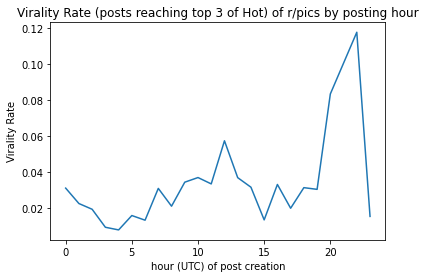

In [19]:
df['hour'] = df['createdTSUTC'].apply(lambda x: x.hour)
viralityByHour = df[['hour', 'target']].groupby('hour').mean().reset_index(drop=False)
x = viralityByHour['hour']
y = viralityByHour['target']
plt.plot(x,y)
plt.xlabel('hour (UTC) of post creation')
plt.title('Virality Rate (posts reaching top 3 of Hot) of r/pics by posting hour')
plt.ylabel('Virality Rate')
plt.show()

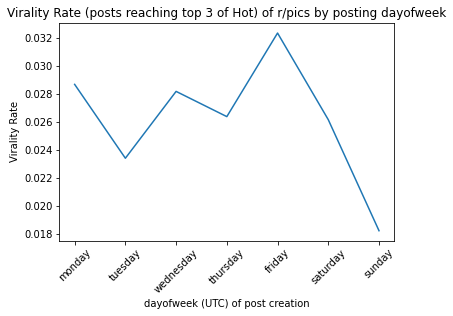

In [33]:
df['dayofweek'] = df['createdTSUTC'].apply(lambda x: x.dayofweek)
viralityByDayOfWeek = df[['dayofweek', 'target']].groupby('dayofweek').mean().reset_index(drop=False)
x = viralityByDayOfWeek['dayofweek']
y = viralityByDayOfWeek['target']
plt.plot(x,y)
plt.xlabel('dayofweek (UTC) of post creation')
plt.title('Virality Rate (posts reaching top 3 of Hot) of r/pics by posting dayofweek')
plt.ylabel('Virality Rate')
plt.xticks(ticks=list(range(0,7)), labels=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], rotation=45)
plt.show()

__Insights 2023-05-03:__

After updating the insights, we still see that there is a relatively low number of posts reaching rising between 3-6pm EST, and none between 5-6pm. I still think this is due to increased volume of posts. Despite this we see these ranges have a high proportion of viral posts, which I think could be because the posts rotate faster due to their high volume.

We also have enough data now to see som weekly trends and it appears sunday has the lowest share of viral posts. This matched up with some real experience where the bot was returning few posts on sunday.


__Insights 2023-04-20:__

These insights are really fascinating so far but would probably warrant a second glance when more data is available. We can see that posts never even make it to rising if posted around 3-6pm EST. My guess is that there is such an influx of content from kids getting out of school and people getting off of work that nothing posted in this region makes it to rising. As such, it could be good to have encode a flag designating these hours. 

It's also interesting to see that right now 8% of posts made at 8am go viral, with some other peaks at about 12pm and 6pm. This is still very noisy and I think more data needs to be collected before we can draw anything conclusive about these hours.